In [1]:
import keras
from keras.models import Sequential
from PIL import Image
import numpy as np

Using TensorFlow backend.


In [2]:
import pandas as pd

In [3]:
from IPython.display import display
def show(X):
    display(Image.fromarray(X))

In [4]:
import keras.backend as K
K.set_image_data_format('channels_last')

In [5]:
base_model = keras.applications.vgg16.VGG16(weights = 'imagenet',  include_top = False, input_shape=(64,64,3))

In [6]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [7]:
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.optimizers import Adam

_ = base_model.get_layer("block5_conv3").output
_ = GlobalAveragePooling2D()(_)
_ = Dense(512, activation='tanh')(_)
_ = Dense(12, activation='tanh')(_)

# 3 個輸出
predictions = Dense(3, activation='softmax')(_)

# 這是我們的 model
model = Model(inputs=base_model.input, outputs=predictions)

for n in ["block5_conv1", "block5_conv2", "block5_conv3"]:
    model.get_layer(n).trainable = True
    
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [10]:
train_data = np.load('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/resize_data/ALL_TRAIN_NOSEG_64.npy')

In [11]:
test_data = np.load('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/resize_data/ALL_TEST_NOSEG_64.npy')

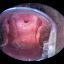

In [12]:
show(train_data[0])

In [39]:
# import glob
# test = glob.glob('/home/dataset/test/*.jpg')
# test = pd.DataFrame([[p.split('/')[4],p] for p in test], columns = ['image','path'])
# test_id = test.image.values
# test.head()
# import cv2
# show(cv2.resize(cv2.imread(test['path'][511]),(64,64))[:,:,::-1])

In [67]:
# import glob
# train1 = glob.glob('/home/dataset/train/**/*.jpg')
# train1 =\
# pd.DataFrame([[p.split('/')[4],p.split('/')[5],p] for p in train1], columns = ['type','image','path'])

# train2 = glob.glob('/home/dataset/Type_*/*.jpg')
# train2 =\
# pd.DataFrame([[p.split('/')[3],p.split('/')[4],p] for p in train2], columns = ['type','image','path'])

# train_ = pd.concat([train1, train2]).reset_index(drop=True)
# train_.head()

In [68]:
# show(cv2.resize(cv2.imread(train['path'][0]),(64,64))[:,:,::-1])

In [13]:
train = pd.read_csv('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/resize_data/TRAIN.csv')
test = pd.read_csv('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/resize_data/TEST.csv')

In [14]:
test_id = test.image.values

In [15]:
le = LabelEncoder()
train_target = le.fit_transform(train['type'].values)

x_train, x_val_train, y_train, y_val_train =\
train_test_split(train_data, train_target, test_size = 0.3, random_state=17)

In [16]:
num_classes = 3
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val_train = keras.utils.to_categorical(y_val_train, num_classes)

In [17]:
x_train = x_train.astype('float32')
x_val_train = x_val_train.astype('float32')

x_train /= 255
x_val_train /= 255

x_test = test_data.astype('float32')
x_test /= 255

In [18]:
from keras.preprocessing.image import ImageDataGenerator

In [19]:
# shift = 0.2
datagen = ImageDataGenerator(rotation_range = 180,\
                             horizontal_flip = True,\
                             vertical_flip = True,\
                             #width_shift_range=shift,\
                             #height_shift_range=shift,\
                             data_format = "channels_last")
datagen.fit(x_train)

In [21]:
model.fit_generator(datagen.flow(x_train, y_train,\
                                 batch_size = 128, shuffle = True),\
                    epochs = 50,\
                    #samples_per_epoch = x_train.shape[0],\
                    steps_per_epoch = 500,\
                    verbose = 1,\
                    validation_data = (x_val_train, y_val_train))

Epoch 1/100
 46/500 [=>............................] - ETA: 115s - loss: 0.9633 - acc: 0.5323

KeyboardInterrupt: 

In [21]:
x_test.shape

(512, 64, 64, 3)

In [23]:
pred = model.predict(x_test)

In [27]:
pred.shape

(512, 3)

In [28]:
df = pd.DataFrame(pred, columns=['Type_1','Type_2','Type_3'])

In [29]:
df['image_name'] = test_id

In [30]:
df = df[['image_name','Type_1','Type_2','Type_3']]

In [31]:
df.head()

,image_name,Type_1,Type_2,Type_3
0,477.jpg,3.079744e-05,0.999937,0.000033
1,178.jpg,9.582960e-05,0.001015,0.998889
2,335.jpg,6.384615e-07,0.002491,0.997509
3,324.jpg,1.097820e-04,0.942784,0.057106
4,98.jpg,1.522068e-04,0.996447,0.003401


In [32]:
sample_submission =\
pd.read_csv('/home/Kaggle_Cervical_Cancer_Screening/submission/sample_submission.csv')

In [33]:
for name in sample_submission['image_name']:
    #print(name)
    #sub[name] = df[df['image_name'] == name][['Type_1','Type_2','Type_3']].values.tolist()[0]
    #print(name)
    Type_1 = df.loc[df['image_name'] == name, 'Type_1']
    Type_2 = df.loc[df['image_name'] == name, 'Type_2']
    Type_3 = df.loc[df['image_name'] == name, 'Type_3']
    
    Type_1_index = Type_1.index[0]
    Type_2_index = Type_2.index[0]
    Type_3_index = Type_3.index[0]
    
    sample_submission.loc[sample_submission['image_name'] == name, 'Type_1'] = Type_1[Type_1_index]
    
    sample_submission.loc[sample_submission['image_name'] == name, 'Type_2'] = Type_2[Type_2_index]
    
    sample_submission.loc[sample_submission['image_name'] == name, 'Type_3'] = Type_3[Type_3_index]

In [34]:
sample_submission.head()

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0.000595,0.999392,0.000012
1,1.jpg,0.000707,0.932164,0.067128
2,2.jpg,0.764460,0.204604,0.030937
3,3.jpg,0.004690,0.940749,0.054561
4,4.jpg,0.000007,0.001063,0.998930


In [35]:
sample_submission.to_csv('/home/Kaggle_Cervical_Cancer_Screening/submission/submission_LB_vgg16_4.csv', index=False)

In [36]:
pd.read_csv('/home/Kaggle_Cervical_Cancer_Screening/submission/submission_LB_vgg16_4.csv').head()

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0.000595,0.999392,0.000012
1,1.jpg,0.000707,0.932164,0.067128
2,2.jpg,0.764460,0.204604,0.030937
3,3.jpg,0.004690,0.940749,0.054561
4,4.jpg,0.000007,0.001063,0.998930
